In [ ]:
pip install datasets


In [ ]:
pip install --upgrade --force-reinstall pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1

In [ ]:
from datasets import load_dataset

dataset = load_dataset("GonzaloA/fake_news")["train"]
abstracts = dataset["text"]
titles = dataset["title"]


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")      # per inglese

def lemmatize_and_remove_stopwords(texts):
    results = []
    for doc in nlp.pipe(texts, batch_size=50, disable=["ner", "parser"]):
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        results.append(" ".join(tokens))
    return results


filtered_abstracts = [abstract for abstract in abstracts[0:5000] if abstract is not None]
abstracts = lemmatize_and_remove_stopwords(filtered_abstracts)

filtered_titles = [title for title in titles[0:5000]if title is not None]
titles = filtered_titles

In [ ]:
abstracts

Column(['Maury is perhaps one of the trashiest shows on television today. It s right in line with the likes of the gutter trash that is Jerry Springer, and the fact that those shows are still on the air with the shit they air really is a sad testament to what Americans find to be entertaining. However, Maury really crossed the line with a Facebook post regarding one of their guest s appearance with a vile, disgusting caption on Tuesday evening.There was a young woman on there doing one of their episodes regarding the paternity of her child. However, on the page, the show posted an image of the woman, who happens to bear a striking resemblance to Senator and presidential candidate Ted Cruz. The caption from the Maury Show page read: The Lie Detector Test determined .that was a LIE!  Ted Cruz is just NOT that SEXY! As if that weren t horrible enough, the caption underneath the Imgur upload reads,  Ted Cruz in drag on Maury. Here is an image from the official Maury Facebook page:Here is t

In [ ]:
pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("thenlper/gte-small")
# Filter out None values from the abstracts list

embeddings = model.encode(abstracts, show_progress_bar=True)
embeddings.shape

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(5000, 384)

In [ ]:
from umap import UMAP
umap_model = UMAP(n_components=5, min_dist=0.0, metric="cosine",
random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [ ]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean",
cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_
len(set(clusters))

21

In [ ]:
import numpy as np
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n")

harare reuters zimbabwe s new president emmerson mnangagwa tuesday announce month amnesty window return public fund illegally stash abroad individual company expiry amnesty end february year government arrest prosecute fail comply mnangagwa say statement mnangagwa swear president friday promise tack... 

dar es salaam reuters tanzanian minister name report result investigation diamond mining industry resign state run television broadcaster say thursday say george simbachawene minister state president s office relinquish post... 

harare reuters high court judge zimbabwe say thursday state s case citizen charge try subvert president robert mugabe s government lack fact order grant bail martha o donovan prison saturday day arrest accusation insult mugabe twitter post police later level charge subversion carry possible year jai... 



(np.float64(-2.1343943893909456),
 np.float64(13.170046430826186),
 np.float64(2.4460131883621217),
 np.float64(14.273072981834412))

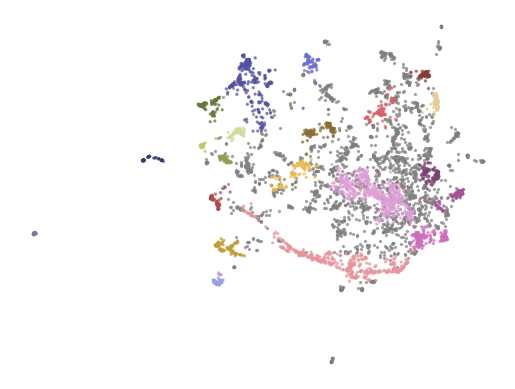

In [ ]:
import pandas as pd
reduced_embeddings = UMAP(n_components=2, min_dist=0, metric="cosine",
random_state=42).fit_transform(embeddings)
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles[:14615]
df["cluster"] = [str(c) for c in clusters]
to_plot_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]
import matplotlib.pyplot as plt
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.6, s=2, c="grey")
plt.scatter(to_plot_df.x, to_plot_df.y, c=to_plot_df.cluster.astype(int),
alpha=0.6, s=2, cmap="tab20b")
plt.axis("off")

In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.8 MB/s eta 0:00:00


In [ ]:


from bertopic import BERTopic
topic_model = BERTopic(
   embedding_model = model,
   umap_model = umap_model,
   hdbscan_model = hdbscan_model,
   verbose=True).fit(abstracts, embeddings)
topic_model.get_topic_info()
topic_model.get_topic(4)

2025-09-05 18:25:13,650 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-05 18:25:26,522 - BERTopic - Dimensionality - Completed ✓
2025-09-05 18:25:26,524 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-05 18:25:26,747 - BERTopic - Cluster - Completed ✓
2025-09-05 18:25:26,753 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-05 18:25:28,315 - BERTopic - Representation - Completed ✓


[('immigration', np.float64(0.04048033931802681)),
 ('ban', np.float64(0.031236960056017136)),
 ('immigrant', np.float64(0.030834592442969412)),
 ('order', np.float64(0.030632358385169825)),
 ('court', np.float64(0.028070904820674977)),
 ('country', np.float64(0.02673792466105824)),
 ('illegal', np.float64(0.02475902824977012)),
 ('say', np.float64(0.024536752441434332)),
 ('trump', np.float64(0.023976044971871377)),
 ('daca', np.float64(0.02348692967528136))]

In [ ]:
topic_model.find_topics("...")

([-1, 7, 0, 3, 9],
 [np.float32(0.8815795),
  np.float32(0.873531),
  np.float32(0.87287736),
  np.float32(0.8615746),
  np.float32(0.85967267)])

In [ ]:
listSTR = [x.strip('()') for x in titles]
listSTR

[' ‘Maury’ Show Official Facebook Posts F*CKED UP Caption On Guest That Looks Like Ted Cruz (IMAGE',
 ' Trump’s Favorite News Channel Tries To Soothe His Battered Ego – Gets Taken To The Cleaners',
 'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote',
 'WATCH STEVE SCALISE Throw A Strike At The Nationals Baseball Game [Video]',
 ' Trump Will HATE What Stephen Colbert Just Did To Him – It’s Pure Comedy Genius (VIDEO',
 'Trump Blasts Democrats: A ‘disgrace’ that Full Cabinet Not in Place, ‘Obstruction by Democrats!’',
 "EU's Verhofstadt\xa0pokes fun at British PM May but says a Brexit deal can be done",
 'Photographer killed in Mexico as journalist death toll nears record',
 ' NY Daily News Runs Most Explosive Trump Cover Yet; Says What We’re All Thinking (IMAGE',
 'BRILLIANT! CNN ASKS BLACK TRUMP SUPPORTER The Wrong Question…They Get Slammed! [Video]',
 "Trump campaign's digital director to meet House intelligence panel: WSJ",
 'U.S Treasury’s Lew says Colombia 

In [ ]:
listSTR = [x.strip('()') for x in titles]
fig = topic_model.visualize_documents(listSTR, reduced_embeddings = reduced_embeddings, width = 1200, hide_annotations = True)
fig.update_layout(font = dict(size = 16))
topic_model.visualize_barchart()